In [391]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from collections import defaultdict
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
import seaborn as sns

In [299]:
take_home = pd.read_csv('takehome_users.csv', encoding='latin1')
take_home


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0
...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1.378448e+09,0,0,89,8263.0
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,NaN
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1.398603e+09,1,1,83,8074.0
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,NaN


In [352]:
user_engagement = pd.read_csv('takehome_user_engagement.csv',parse_dates=['time_stamp'])
user_engagement

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1
...,...,...,...
207912,2013-09-06 06:14:15,11996,1
207913,2013-01-15 18:28:37,11997,1
207914,2014-04-27 12:45:16,11998,1
207915,2012-06-02 11:55:59,11999,1


In [301]:
for i in range(len(user_engagement)):
    user_engagement.time_stamp[i] = pd.to_datetime(user_engagement.time_stamp[i])

C:\Users\khaiv\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [341]:
#Created week tab to count all the timestamps of the user during the week
user_engagement['week'] = user_engagement['time_stamp'].dt.week
user_logins = user_engagement.groupby(['week', 'user_id'])['time_stamp'].count()

#Dropped duplicates and counted the number of weekly logins and added the "adopted user" by the index.
user_logins = user_logins.reset_index()
user_logins.columns = ['week', 'user_id','weekly_logins']
user_logins = user_logins.drop('week', axis=1)
adopted_user_list = list(user_logins[user_logins.weekly_logins >= 3].drop_duplicates().index)

#List that identifies user has an adopted user, 1 if they are 0 if they aren't.
adopt_list = []
for i in range(len(user_engagement)):
    if user_engagement.user_id[i] in adopted_user_list:
        adopt_list.append(1)
    else:
        adopt_list.append(0)
#user_logins['adopted_user'].value_counts()


In [362]:
user_engagement['adopted_user'] = adopt_list


In [364]:
#Merged the two datasets and opted to dropped the NaNs, since the dataset is so large.
take_home.columns = ['user_id', 'creation_time', 'name', 'email', 'creation_source',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id']
df = take_home.merge(user_engagement, on='user_id', how='left')
df.dropna(inplace=True)

In [371]:
df['creation_source_cat'] = df['creation_source'].astype('category')
df['creation_source_cat'] = df['creation_source_cat'].cat.codes
df

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,time_stamp,visited,adopted_user,creation_source_cat
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,2014-04-22 03:53:30,1.0,1.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2013-11-15 03:45:04,1.0,1.0,1
2,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2013-11-29 03:45:04,1.0,1.0,1
3,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2013-12-09 03:45:04,1.0,1.0,1
4,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2013-12-25 03:45:04,1.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211041,11981,2013-03-05 01:53:48,Fry Tyler,TylerFry@gmail.com,GUEST_INVITE,1.364868e+09,0,0,110,5775.0,2013-04-02 01:53:48,1.0,1.0,0
211042,11982,2013-12-06 14:39:15,Barajas Maria,MariaCBarajas@gmail.com,ORG_INVITE,1.386341e+09,1,1,57,2527.0,2013-12-06 14:39:15,1.0,0.0,1
211079,11990,2013-07-05 21:00:48,Juhl Aase,AasePJuhl@jourrapide.com,ORG_INVITE,1.373144e+09,0,0,25,3944.0,2013-07-06 21:00:48,1.0,0.0,1
211089,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1.378448e+09,0,0,89,8263.0,2013-09-06 06:14:15,1.0,0.0,1


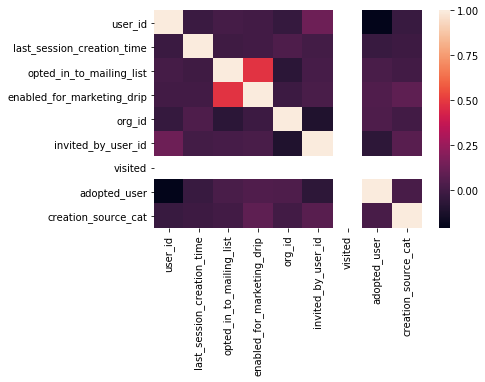

In [375]:
#Decided to look for correlations between any of the variables, very low excluding opted_in_to_mailing_list and 
#enabled_for_marketing_drip.
corr = df.corr()
_ = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

In [376]:
df.columns

Index(['user_id', 'creation_time', 'name', 'email', 'creation_source',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id',
       'time_stamp', 'visited', 'adopted_user', 'creation_source_cat'],
      dtype='object')

In [398]:
X = df[['user_id', 'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id', 'creation_source_cat']]
y = df['adopted_user']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('R^2: {}'.format(model.score(X_test, y_test)))
print('Root Mean Squared Error: {}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))

C:\Users\khaiv\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


R^2: 0.9907605441012918
Root Mean Squared Error: 0.09612208850575495


In [386]:
sel = SelectFromModel(RandomForestClassifier(n_estimators=100))
sel.fit(X_train, y_train)
sel.get_support()
selected_feat = X_train.columns[(sel.get_support())]
print(selected_feat)

Index(['user_id', 'last_session_creation_time', 'org_id',
       'invited_by_user_id'],
      dtype='object')


In [400]:
X = df[selected_feat]
y = df['adopted_user']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('R^2: {}'.format(model.score(X_test, y_test)))
print('Root Mean Squared Error: {}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))

C:\Users\khaiv\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


R^2: 0.9917871503122594
Root Mean Squared Error: 0.09062477413897709


In [392]:
target_names = ['Adopted', 'Not adopted']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     Adopted       0.99      1.00      0.99     17221
 Not adopted       0.99      0.97      0.98      6157

    accuracy                           0.99     23378
   macro avg       0.99      0.99      0.99     23378
weighted avg       0.99      0.99      0.99     23378



In [394]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, y_pred)
cf_matrix

array([[17160,    61],
       [  156,  6001]], dtype=int64)

Adopted users were predicted at a very high accuracy using 'user_id', 'last_session_creation_time', 'org_id', and 'invited_by_user_id' variables. I would add more variables or try more feature engineering to get more insights on what contributes to adopted users besides organization id, which notes what companies use the product and which don't. What would be interesting is to know what industries utilize the product and see if there was a correlation there.